## Задание
1. В качестве исходного датасета используется MNIST, содержащий изображения чисел от 0 до 9.
2. Генерируется ряд, состоящий из 10 случайным образом выбранных чисел.
3. Необходимо создать модель, предсказывающую 11-й член ряда a<sub>11</sub> = a<sub>1</sub> + a<sub>2</sub>.

## Решение

### Импорт модулей

In [104]:
import pandas as pd
import numpy as np
from keras.models import load_model
from matplotlib import pyplot as plt
from datagenerators import DataGeneratorRegression, DataGeneratorClassification

### Вспомогательные функции

Функция, выполняющая декодирование меток из One-hot encoding в массив ответов

In [77]:
def decode_preds(*args):
    """
    Декодирует метки из формата one-hot encodint в
    массив int. Можно передавать несколько аргументов
    для декодирования.
    """
    answers = []
    for answ_arr in args:
        answers.append(np.argmax(answ_arr, axis=1))    
    return tuple(answers) if len(answers)>1 else answers[0]    

Функция для вывода изображений

In [78]:
def plot_batch(batch, num=0, plot_full=False):
    """
    Выводит изображения из переданного батча.
    Args:
        batch (np.array): батч изображений;
        num (int): номер последовательности из батча;
        plot_full (bool): Если True, выводит всю последовательность
            изображений. Если False - только первые два, на основе
            которых считается ответ.
    """
    if plot_full:
        fig=plt.figure(figsize=(16, 6))
        columns = 5
        rows = 2
        for i in range(1, columns*rows+1):
            img = batch[num][i-1]
            img = img.reshape(img.shape[0], img.shape[1])
            fig.add_subplot(rows, columns, i)
            plt.imshow(img, cmap='gray')
    else:
        fig=plt.figure(figsize=(10, 6))
        columns = 2
        rows = 1
        for i in range(1, columns*rows+1):
            img = batch[num][i-1]
            img = img.reshape(img.shape[0], img.shape[1])
            fig.add_subplot(rows, columns, i)
            plt.imshow(img, cmap='gray')            
    plt.show()

### Создание модели
Для выполнения задания была реализована модель с использованием слоев Convolutional LSTM. Данные слои аналогичны слоям LSTM, но входные и рекуррентные преобразования сверточные. (https://arxiv.org/abs/1506.04214v1)

Было реализовано две модели: одна выполняет классификацию, другая — регрессию.

Реализация модели, выполняющей классификацию, приведена в <i>model_classification.py</i>.

Реализация модели, выполняющей регрессию, приведена в <i>model_regression.py</i>.

Веса обученных моделей находятся в директории <i>models</i>.

### Проверка точности моделей

Параметры моделей

In [100]:
h = 28 # высота изображений
w = 28 # ширина изображений
c = 1 # количество каналов
seq_len = 10 # длина последовательности изображений
input_shape = (seq_len, h, w, c)
bs = 32 # batch size

#### Регрессия

In [101]:
model = load_model("models/model_regression.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 10, 28, 28, 16)    9856      
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 10, 28, 28, 32)    55424     
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 10, 28, 28, 64)    221440    
_________________________________________________________________
flatten_1 (Flatten)          (None, 501760)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 501760)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 501761    
Total params: 788,481
Trainable params: 788,481
Non-trainable params: 0
________________________________________________

Подготовка данных. Реализация генераторов находится в <i>datagenerators.py</i>.

In [105]:
test_df = pd.read_csv("mnist_data/mnist_test.csv")
test_data = DataGeneratorRegression(test_df, batch_size=bs,
                                    dim=input_shape)

In [107]:
_, accuracy = model.evaluate(test_data, verbose=0)
print('Accuracy on test data: {:.4f}'.format(accuracy))

Accuracy on test data: 0.3649


#### Классификация

Для классификации выполняется разделение на 19 классов: от 0 включительно (0+0) до 18 (9+9).

In [109]:
model = load_model("models/model_classification.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 10, 28, 28, 16)    9856      
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 10, 28, 28, 32)    55424     
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 10, 28, 28, 64)    221440    
_________________________________________________________________
flatten_1 (Flatten)          (None, 501760)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 501760)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 19)                9533459   
Total params: 9,820,179
Trainable params: 9,820,179
Non-trainable params: 0
____________________________________________

In [110]:
test_df = pd.read_csv("mnist_data/mnist_test.csv")
test_data = DataGeneratorClassification(test_df, batch_size=bs,
                                        dim=input_shape)

In [111]:
_, accuracy = model.evaluate(test_data, verbose=0)
print('Accuracy on test data: {:.4f}'.format(accuracy))

Accuracy on test data: 0.9153


### Итог

Как видно, при одинаковой архитектуре модель с классификацие достигает гораздо большей точности, однако параметров у данной модели в 10 раз больше.

### Визуализация. Проверка работоспособности модели на примерах.

Получим батч данных из генератора

In [114]:
for X, y in test_data:
    break

Получим предсказания модели и выполним декодирование меток

In [116]:
y_pred = model.predict(X)
y, y_pred = decode_preds(y, y_pred)

Проверка работоспособности

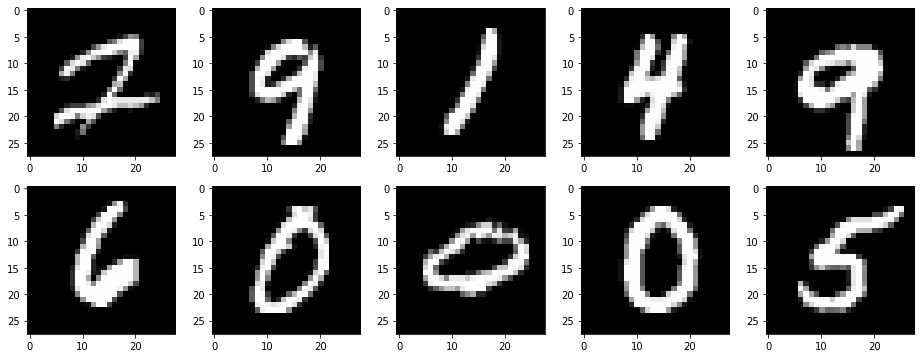

Ground truth: 11, predicted: 11


In [117]:
num_in_batch = 0 # Номер последовательности в батче
plot_batch(X, num=num_in_batch, plot_full=True)
print("Ground truth: {}, predicted: {}".format(y[num_in_batch],
                                               y_pred[num_in_batch]))

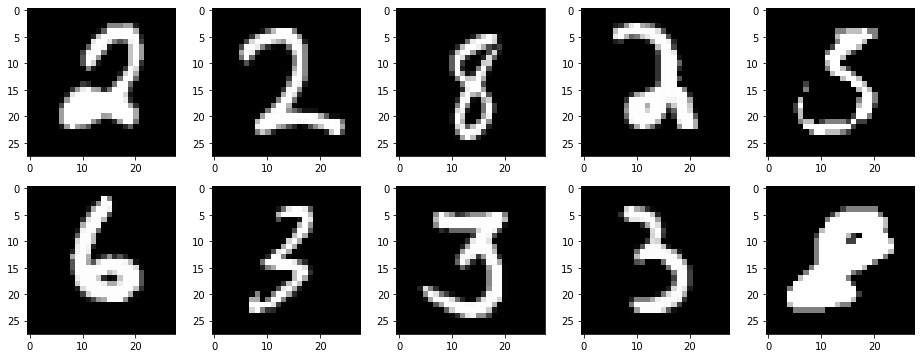

Ground truth: 4, predicted: 4


In [118]:
num_in_batch = 2 # Номер последовательности в батче
plot_batch(X, num=num_in_batch, plot_full=True)
print("Ground truth: {}, predicted: {}".format(y[num_in_batch],
                                               y_pred[num_in_batch]))

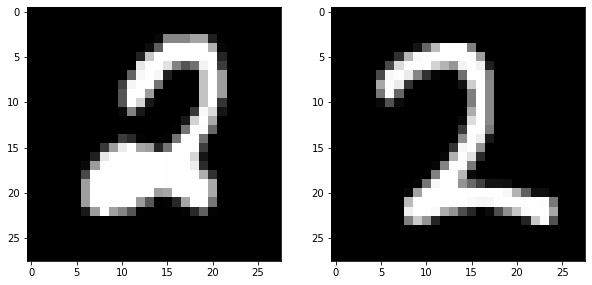

Ground truth: 4, predicted: 4



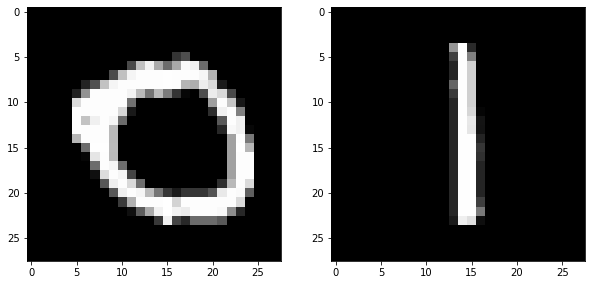

Ground truth: 1, predicted: 1



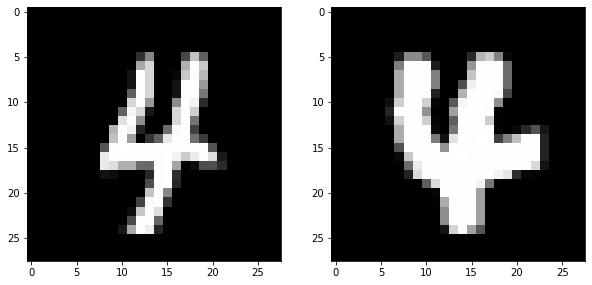

Ground truth: 8, predicted: 8



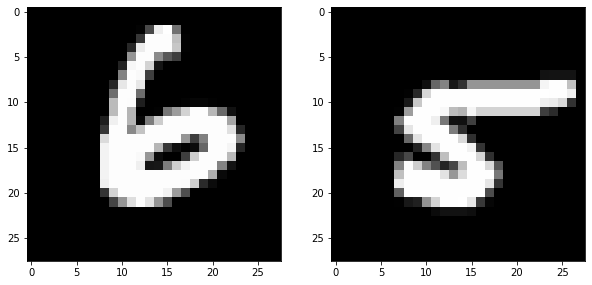

Ground truth: 11, predicted: 11



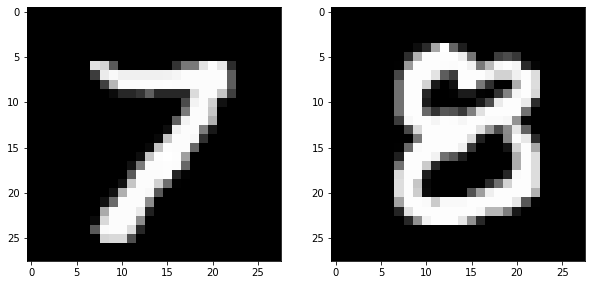

Ground truth: 15, predicted: 15



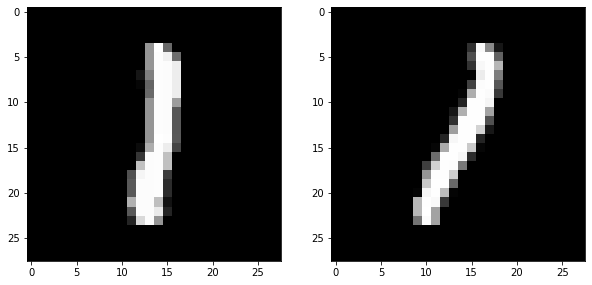

Ground truth: 2, predicted: 2



In [119]:
for i in range(2, 8):
    plot_batch(X, num=i, plot_full=False)
    print("Ground truth: {}, predicted: {}\n"
          .format(y[i], y_pred[i]))
    print('='*74)